Experiment with downsampling certain samples we have an even distribution between severity levels 1-4.

We'll use the features that a have already been generated for our current best experiment (third sentinel + land cover features, trained with folds). Compare the results to that [best experiment](https://docs.google.com/presentation/d/1zWrSMSivxylx_iH_aOapJfyziRsDuyuXOELduOn6x3c/edit#slide=id.g278eb39bdd6_0_43)

**Takeaway**

- Performance is better in the west, but significantly worse in other regions
- Log(density) metrics are worse (R-squared and MAPE)
- R-squared is better in the west, but much worse in all other regions
- Based on the crosstab, the model does appear better at identifying severities 3 and 4, and distinguishing between severities 2 and 3. Severity level 2 predictions are also generally higher. However, performance is much worse on severity 1.

On balance, it does not seem worth it to downsample severities 1 and 4

In [7]:
%load_ext lab_black
%load_ext autoreload
%autoreload 2

The lab_black extension is already loaded. To reload it, use:
  %reload_ext lab_black
The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [8]:
import shutil

from cloudpathlib import AnyPath
import pandas as pd

from cyano.data.utils import add_unique_identifier
from cyano.experiment.experiment import ExperimentConfig
from cyano.pipeline import CyanoModelPipeline
from cyano.settings import RANDOM_STATE

In [3]:
tmp_dir = AnyPath("tmp_dir")
tmp_dir.mkdir(exist_ok=True)

In [4]:
experiment_dir = AnyPath(
    "s3://drivendata-competition-nasa-cyanobacteria/experiments/results/third_sentinel_with_folds"
)

In [5]:
train_features = pd.read_csv(experiment_dir / "features_train.csv", index_col=0)
train_features.head()

,AOT_mean,AOT_min,AOT_max,AOT_range,B01_mean,B01_min,B01_max,B01_range,B02_mean,B02_min,...,WVP_min,WVP_max,WVP_range,NDVI_B04,NDVI_B05,NDVI_B06,NDVI_B07,month,days_before_sample,land_cover
sample_id,,,,,,,,,,,,,,,,,,,,,
0001cfa683171fe80161cdbe6a090c94,102.0,102.0,102.0,0.0,319.843750,144.0,1083.0,939.0,441.956349,146.0,...,277.0,1413.0,1136.0,0.581754,0.418335,0.114064,0.033551,2.0,15.0,11
0001cfa683171fe80161cdbe6a090c94,132.0,132.0,132.0,0.0,435.984375,229.0,1055.0,826.0,503.288549,154.0,...,167.0,828.0,661.0,0.574375,0.418914,0.120972,0.042572,3.0,8.0,11
0001cfa683171fe80161cdbe6a090c94,204.0,204.0,204.0,0.0,902.640625,703.0,1661.0,958.0,938.553288,672.0,...,931.0,931.0,0.0,0.455419,0.329302,0.097910,0.027511,3.0,5.0,11
0001cfa683171fe80161cdbe6a090c94,102.0,102.0,102.0,0.0,518.484375,316.0,1554.0,1238.0,618.096939,277.0,...,574.0,1436.0,862.0,0.548216,0.391690,0.115218,0.032818,2.0,13.0,11
0001cfa683171fe80161cdbe6a090c94,102.0,102.0,102.0,0.0,318.218750,104.0,1314.0,1210.0,485.587302,162.0,...,340.0,1114.0,774.0,0.582335,0.425137,0.129981,0.039196,2.0,10.0,11


In [6]:
# add in actual labels
train = pd.read_csv(
    AnyPath(
        "s3://drivendata-competition-nasa-cyanobacteria/experiments/splits/competition/train.csv"
    )
)
train = add_unique_identifier(train)
train.head(2)

,uid,data_provider,region,latitude,longitude,date,density_cells_per_ml,severity,distance_to_water_m,log_density
sample_id,,,,,,,,,,
d7ebbce63c7d1498cc627a1e77f6061c,aabm,Indiana State Department of Health,midwest,39.080319,-86.430867,2018-05-14,585.0,1,0.0,6.373320
0856c3740614b5ee606f82d6c3a215a0,aacd,N.C. Division of Water Resources N.C. Departme...,south,35.875083,-78.878434,2020-11-19,290.0,1,514.0,5.673323


## Select samples

Select which samples we'll keep in our training

In [9]:
train.severity.value_counts().sort_index()

severity
1    7497
2    3239
3    2719
4    3547
5      58
Name: count, dtype: int64

In [10]:
(sample_size := train.severity.value_counts().loc[2])

3239

In [11]:
# shuffle train
train = train.sample(frac=1, random_state=RANDOM_STATE)

# select first n for each severity
downsampled_train = []
for severity in train.severity.unique():
    downsampled_train.append(train[train.severity == severity].head(sample_size))
downsampled_train = pd.concat(downsampled_train)

downsampled_train.severity.value_counts().sort_index()

severity
1    3239
2    3239
3    2719
4    3239
5      58
Name: count, dtype: int64

In [12]:
downsampled_train.shape

(12494, 10)

In [13]:
train_features = train_features[train_features.index.isin(downsampled_train.index)]
train_features.shape

(32429, 67)

In [14]:
train_features.index.nunique()

8620

In [15]:
train_features.head()

,AOT_mean,AOT_min,AOT_max,AOT_range,B01_mean,B01_min,B01_max,B01_range,B02_mean,B02_min,...,WVP_min,WVP_max,WVP_range,NDVI_B04,NDVI_B05,NDVI_B06,NDVI_B07,month,days_before_sample,land_cover
sample_id,,,,,,,,,,,,,,,,,,,,,
0001cfa683171fe80161cdbe6a090c94,102.0,102.0,102.0,0.0,319.843750,144.0,1083.0,939.0,441.956349,146.0,...,277.0,1413.0,1136.0,0.581754,0.418335,0.114064,0.033551,2.0,15.0,11
0001cfa683171fe80161cdbe6a090c94,132.0,132.0,132.0,0.0,435.984375,229.0,1055.0,826.0,503.288549,154.0,...,167.0,828.0,661.0,0.574375,0.418914,0.120972,0.042572,3.0,8.0,11
0001cfa683171fe80161cdbe6a090c94,204.0,204.0,204.0,0.0,902.640625,703.0,1661.0,958.0,938.553288,672.0,...,931.0,931.0,0.0,0.455419,0.329302,0.097910,0.027511,3.0,5.0,11
0001cfa683171fe80161cdbe6a090c94,102.0,102.0,102.0,0.0,518.484375,316.0,1554.0,1238.0,618.096939,277.0,...,574.0,1436.0,862.0,0.548216,0.391690,0.115218,0.032818,2.0,13.0,11
0001cfa683171fe80161cdbe6a090c94,102.0,102.0,102.0,0.0,318.218750,104.0,1314.0,1210.0,485.587302,162.0,...,340.0,1114.0,774.0,0.582335,0.425137,0.129981,0.039196,2.0,10.0,11


## Train model

Train a model on the downsampled features

In [16]:
# Load best yaml config
experiment = ExperimentConfig.from_file(experiment_dir / "config_artifact.yaml")

In [17]:
pipe = CyanoModelPipeline(
    features_config=experiment.features_config,
    model_training_config=experiment.model_training_config,
    target_col=experiment.target_col,
)

In [18]:
pipe.model_training_config

ModelTrainingConfig(params=LGBParams(application='regression', metric='rmse', max_depth=-1, num_leaves=31, learning_rate=0.1, verbosity=-1, early_stopping_round=100, bagging_seed=40, seed=40), num_boost_round=100000, n_folds=5)

In [19]:
pipe.train_features = train_features
pipe.train_labels = downsampled_train["log_density"]
pipe.train_samples = downsampled_train[["date", "latitude", "longitude", "region"]]

In [21]:
pipe._train_model()

2023-08-28 15:59:45.830 | INFO     | cyano.pipeline:_train_model:128 - Training 5 model folds


In [23]:
pipe._to_disk(tmp_dir / "downsampled_model.zip")

2023-08-28 16:31:38.586 | INFO     | cyano.pipeline:_to_disk:177 - Saving model to downsampled_model.zip


## Predict

In [20]:
# read in test features and test samples
test = pd.read_csv(
    AnyPath(
        "s3://drivendata-competition-nasa-cyanobacteria/experiments/splits/competition/test.csv"
    )
)
test = add_unique_identifier(test)
print(test.shape)

test_features = pd.read_csv(experiment_dir / "features_test.csv", index_col=0)
print(test_features.shape)

(6510, 10)
(21492, 67)


In [21]:
pipe.predict_samples = test[["date", "latitude", "longitude"]]
pipe.predict_features = test_features

In [26]:
pipe._predict_model()

2023-08-28 16:32:14.825 | INFO     | cyano.pipeline:_predict_model:221 - Ensembling 5 models
2023-08-28 16:41:28.622 | INFO     | cyano.pipeline:_predict_model:233 - Grouping 107,460 predictions by 4,824 unique sample IDs
2023-08-28 16:41:28.660 | WARNING  | cyano.pipeline:_predict_model:258 - 1,686 samples do not have predictions (26%)


In [27]:
pipe._write_predictions(tmp_dir / "preds.csv")

2023-08-28 16:41:28.783 | SUCCESS  | cyano.pipeline:_write_predictions:265 - Predictions saved to preds.csv


## Evaluate

In [22]:
from cyano.evaluate import (
    EvaluatePreds,
    generate_and_plot_crosstab,
    generate_actual_density_boxplot,
    generate_density_scatterplot,
    generate_density_kdeplot,
)

In [23]:
ep = EvaluatePreds(
    y_true_csv=AnyPath(
        "s3://drivendata-competition-nasa-cyanobacteria/experiments/splits/competition/test.csv"
    ),
    y_pred_csv="preds.csv",
    save_dir="eval",
)

2023-08-28 16:56:58.309 | INFO     | cyano.evaluate:__init__:125 - Evaluating on 4,824 samples (of 6,510)


#### Severity predictions

In [24]:
severity_results = ep.calculate_severity_metrics(
    y_true=ep.y_true_df["severity"], y_pred=ep.y_pred_df["severity"], region=ep.region
)

{key: item for key, item in severity_results.items() if key != "classification_report"}

{'overall_rmse': 1.039138723606641,
 'overall_mae': 0.724502487562189,
 'overall_mape': 0.4489566058595909,
 'regional_rmse': {'midwest': 0.9423691959590664,
  'northeast': 1.0434850628281327,
  'south': 1.2047842199839804,
  'west': 0.9715611107851846},
 'region_averaged_rmse': 1.040549897389091,
 'regional_mae': {'midwest': 0.6509121061359867,
  'northeast': 0.7709637046307884,
  'south': 0.9481605351170569,
  'west': 0.5914972273567468}}

<Axes: xlabel='Actual severity', ylabel='Predicted severity'>

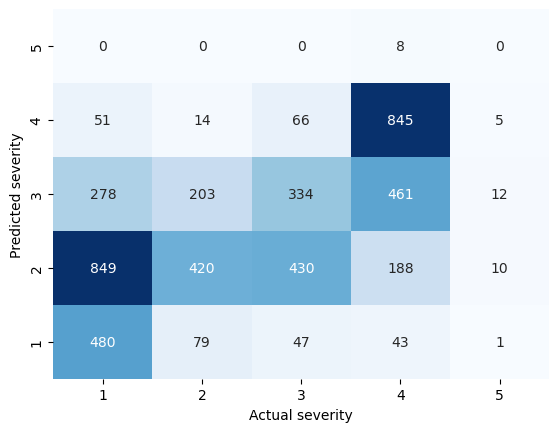

In [25]:
generate_and_plot_crosstab(ep.y_true_df.severity, ep.y_pred_df.severity)

<Axes: xlabel='Predicted severity', ylabel='Actual density (cells/mL)'>

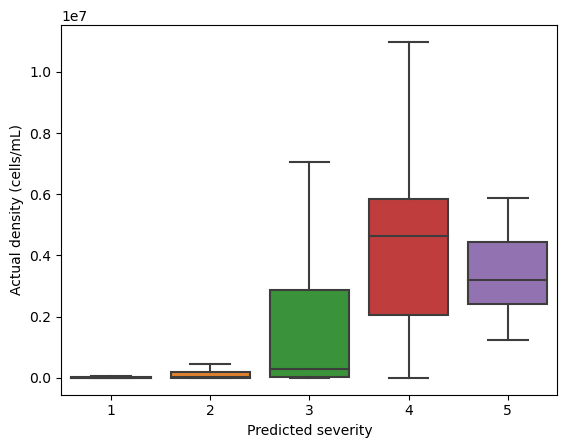

In [26]:
generate_actual_density_boxplot(
    ep.y_true_df.density_cells_per_ml, ep.y_pred_df.severity
)

#### Log(density) predictions

In [27]:
ep.calculate_density_metrics(
    y_true=ep.y_true_df.log_density, y_pred=ep.y_pred_df.log_density, region=ep.region
)

{'overall_r_squared': 0.33783129806156986,
 'overall_mape': 844249784945572.2,
 'regional_r_squared': {'midwest': 0.21316562793933114,
  'northeast': -0.13915249519993123,
  'south': -0.5101570061588583,
  'west': -1.0583688609398534}}

<Axes: xlabel='Actual log_density', ylabel='Predicted log_density'>

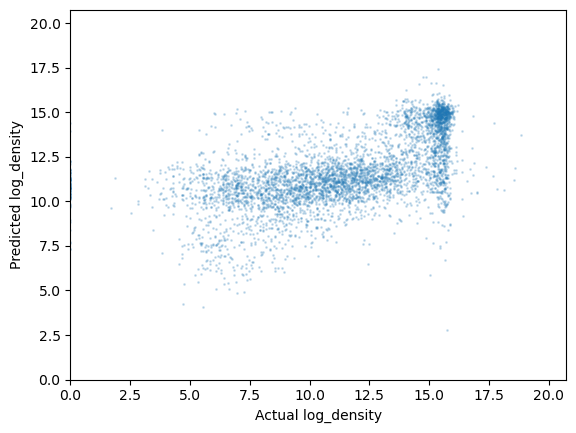

In [28]:
generate_density_scatterplot(ep.y_true_df["log_density"], ep.y_pred_df["log_density"])

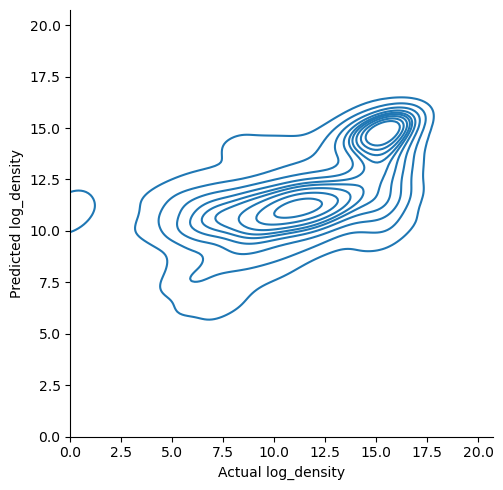

In [29]:
generate_density_kdeplot(ep.y_true_df.log_density, ep.y_pred_df.log_density)

In [ ]:
shutil.rmtree(tmp_dir)